In [1]:
# General
import numpy as np

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Pauli

# Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator

# Plotting routines
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
#tkn="1799e0c073f8102055fccaf72962199a1f385c892139071e391d6a3ad63c7dd6956ba2525f23b8799d42946e035ea483fd7e942d0b7baa634f05e90cd7ef4831"
#from qiskit_ibm_runtime import QiskitRuntimeService
 
# Save an IBM Quantum account and set it as your default account.
#QiskitRuntimeService.save_account(channel="ibm_quantum", token=tkn, set_as_default=True)

In [2]:
service = QiskitRuntimeService()
backend = service.get_backend("ibm_brisbane") 
# ibm_brisbane - 127 qbits
# ibm_perth - 7 qubits
# ibm_lagos - 7 qubits
# ibm_nairobi - 7 qubits
# simulator_stabilizer - 5000 qubits
# simulator_mps - 100 qubits
# simulator_extended_stabilizer - 63 qubits
# ibmq_qasm_simulator - 32 qubits
# simulator_statevector - 32 qubits

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


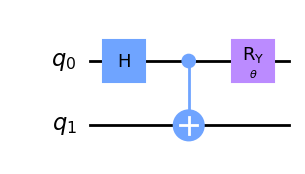

In [3]:
theta = Parameter("$\\theta$")

chsh_circuit_no_meas = QuantumCircuit(2)
chsh_circuit_no_meas.h(0)
chsh_circuit_no_meas.cx(0, 1)
chsh_circuit_no_meas.ry(theta, 0)
chsh_circuit_no_meas.draw("mpl")

In [4]:
number_of_phases = 21
phases = np.linspace(0, 2 * np.pi, number_of_phases)
# Phases need to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]

In [5]:
ZZ = SparsePauliOp.from_list([("ZZ", 1)])
ZX = SparsePauliOp.from_list([("ZX", 1)])
XZ = SparsePauliOp.from_list([("XZ", 1)])
XX = SparsePauliOp.from_list([("XX", 1)])

ops = [ZZ, ZX, XZ, XX]
num_ops = len(ops)


In [6]:
batch_circuits = [chsh_circuit_no_meas] * number_of_phases * num_ops
batch_ops = [op for op in ops for _ in individual_phases]

In [7]:
estimator = Estimator(backend)

batch_expvals = (
    estimator.run(
        batch_circuits, batch_ops, parameter_values=individual_phases * num_ops, shots=int(1e4)
    )
    .result()
    .values
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1072: UserWarning: Your current pending jobs are estimated to consume 651.1150956778592 quantum seconds, but you only have 600 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)
runtime_job._start_websocket_client:WARNING:2023-11-13 17:14:56,436: An error occurred while streaming results from the server for job cn9avqypb7t0008r2rbg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit_ibm_runtime/runtime_job.py", line 536, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit_ibm_provider/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_facto

In [8]:
ZZ_expval, ZX_expval, XZ_expval, XX_expval = [
    batch_expvals[kk * number_of_phases : (kk + 1) * number_of_phases] for kk in range(num_ops)
]

In [9]:
# <CHSH1> = <AB> - <Ab> + <aB> + <ab>
chsh1_est = ZZ_expval - ZX_expval + XZ_expval + XX_expval

# <CHSH2> = <AB> + <Ab> - <aB> + <ab>
chsh2_est = ZZ_expval + ZX_expval - XZ_expval + XX_expval

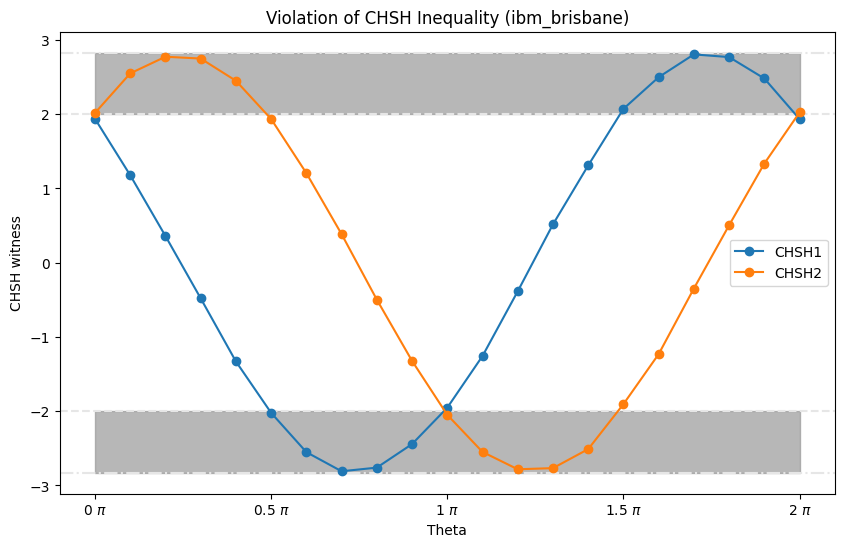

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
# results from hardware
ax.plot(phases / np.pi, chsh1_est, "o-", label="CHSH1", zorder=3)
ax.plot(phases / np.pi, chsh2_est, "o-", label="CHSH2", zorder=3)
# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")
# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)
# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
# set title, labels, and legend
plt.title(f"Violation of CHSH Inequality ({backend.name})")
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend();